In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import os

# Load data and preprocess

In [2]:
dapi_name = 'cyc_1_dapi.tif'
BASE_DIR = Path('E:/TMC/PRISM_pipeline/dataset/processed')
RUN_ID = '_example_dataset'
src_dir = BASE_DIR / f'{RUN_ID}_processed'
stc_dir = src_dir / 'stitched'
read_dir = src_dir / 'readout'
seg_dir = src_dir / 'segmented'
os.makedirs(seg_dir, exist_ok=True)

In [3]:
intensity = pd.read_csv(read_dir/'intensity_deduplicated.csv')

In [11]:
G_layer = 2
color_grade = 5
channel = ['Ye/A', 'B/A', 'R/A',]
num_per_layer = int(color_grade * (color_grade + 1)/2)

## Overview of data distribution

In [124]:
RYB_x_transform = np.array([[-np.sqrt(2)/2], [0], [np.sqrt(2)/2]])
RYB_y_transform = np.array([[-np.sqrt(3)/3], [2/np.sqrt(3)], [-np.sqrt(3)/3]])
# RYB_x_transform = np.array([[-np.sqrt(2)/2], [np.sqrt(2)/2], [0]])
# RYB_y_transform = np.array([[-1/2], [-1/2], [np.sqrt(2)/4]])
RYB_xy_transform = np.concatenate([RYB_x_transform, RYB_y_transform], axis=1)
intensity['sum'] = intensity['Scaled_R'] + intensity['Scaled_Ye'] + intensity['Scaled_B']
intensity['R/A'] = intensity['Scaled_R'] / intensity['sum']
intensity['Ye/A'] = intensity['Scaled_Ye'] / intensity['sum']
intensity['B/A'] = intensity['Scaled_B'] / intensity['sum']

intensity = intensity.dropna()

intensity['G/A'] = intensity['Scaled_G'] / intensity['sum']
intensity['G/A'][intensity['G/A'] > 5] = 5
intensity['G/A'] = intensity['G/A'] * np.exp(0.8 * intensity['Ye/A'])
# intensity['G/A'] = intensity['G/A'] * np.exp(0.6 * intensity['B/A'])

intensity['X_coor'] = intensity[channel] @ RYB_x_transform
intensity['Y_coor'] = intensity[channel] @ RYB_y_transform

In [129]:
intensity.to_csv(r'E:\TMC\PRISM_pipeline\dataset\processed\_example_dataset_processed\readout\intensity_scaled.csv')

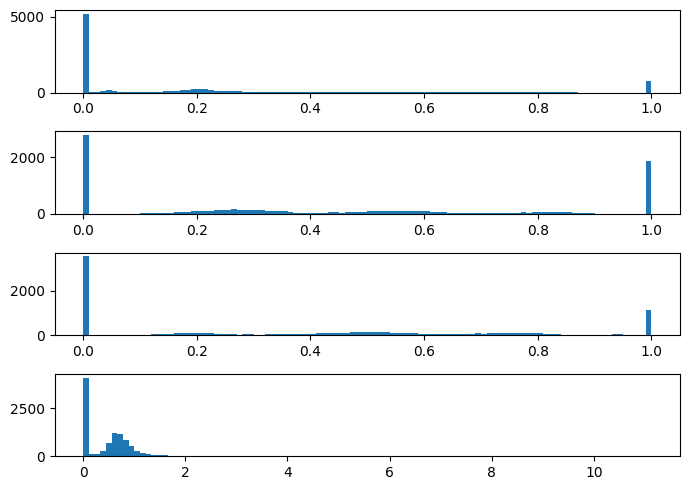

In [125]:
data = intensity.copy()
data = data.sample(10000)
fig, ax = plt.subplots(ncols=1, nrows=4, figsize=(7,5))
ax[0].hist(bins=100, x=data['Ye/A'])
ax[1].hist(bins=100, x=data['B/A'])
ax[2].hist(bins=100, x=data['R/A'])
ax[3].hist(bins=100, x=data['G/A'])
plt.tight_layout()
plt.show()

## Gaussian blur and orthogonal decomposition

In [126]:
num_per_layer = int(color_grade * (color_grade + 1)/2)

RYB_x_transform = np.array([[-np.sqrt(2)/2], [0], [np.sqrt(2)/2]])
RYB_y_transform = np.array([[-np.sqrt(3)/3], [2/np.sqrt(3)], [-np.sqrt(3)/3]])
# RYB_x_transform = np.array([[-np.sqrt(2)/2], [np.sqrt(2)/2], [0]])
# RYB_y_transform = np.array([[-1/2], [-1/2], [np.sqrt(2)/4]])
RYB_xy_transform = np.concatenate([RYB_x_transform, RYB_y_transform], axis=1)

In [120]:
intensity['sum'] = intensity['Scaled_R'] + intensity['Scaled_Ye'] + intensity['Scaled_B']
intensity['R/A'] = intensity['Scaled_R'] / intensity['sum']
intensity['Ye/A'] = intensity['Scaled_Ye'] / intensity['sum']
intensity['B/A'] = intensity['Scaled_B'] / intensity['sum']

intensity['G/A'] = intensity['Scaled_G'] / intensity['sum']
intensity['G/A'] = intensity['G/A'] * np.exp(0.8 * intensity['Ye/A'])
# intensity['G/A'] = intensity['G/A'] * np.exp(0.6 * intensity['B/A'])

intensity['X_coor'] = intensity[channel] @ RYB_x_transform
intensity['Y_coor'] = intensity[channel] @ RYB_y_transform

In [7]:
# intensity['R'] = intensity['R'].astype('int32')
# intensity['Ye'] = intensity['Ye'].astype('int32')
# intensity['B'] = intensity['B'].astype('int32')

# intensity['sum'] = intensity['R'] + intensity['Ye'] + intensity['B']
# intensity['R/A'] = intensity['R'] / intensity['sum']
# intensity['Ye/A'] = intensity['Ye'] / intensity['sum']
# intensity['B/A'] = intensity['B'] / intensity['sum']

# intensity['G/A'] = intensity['G'] / intensity['sum']
# intensity['G/A'] = intensity['G/A'] * np.exp(0.8 * intensity['Ye/A'])

# intensity['X_coor'] = intensity[channel] @ RYB_x_transform
# intensity['Y_coor'] = intensity[channel] @ RYB_y_transform

In [127]:
intensity_fra = intensity[['Ye/A', 'B/A', 'R/A', 'G/A', 'X_coor', 'Y_coor']]
# intensity_fra['G/A'] = np.log(1+np.log(1 + intensity_fra['G/A']))
# intensity_fra['G/A'] = intensity_fra['G/A']/np.percentile(intensity_fra['G/A'], 95)

gaussian = np.concatenate([np.random.normal(loc=0, scale=0.01, size=intensity_fra[channel].shape), np.random.normal(loc=0, scale=0.001, size=intensity_fra[['G/A']].shape)], axis=1)
intensity_fra[channel + ['G/A']] = intensity_fra[channel + ['G/A']].mask(intensity_fra[channel + ['G/A']]==0, gaussian)

gaussian = np.random.normal(loc=0, scale=0.02, size=intensity_fra[channel].shape)
intensity_fra[channel] = intensity_fra[channel].mask(intensity_fra[channel]==1, 1 + gaussian)

intensity_fra['X_coor_gaussian'] = intensity_fra[channel].dot(RYB_x_transform)
intensity_fra['Y_coor_gaussian'] = intensity_fra[channel].dot(RYB_y_transform)

## Overview of preprocessed data distribution

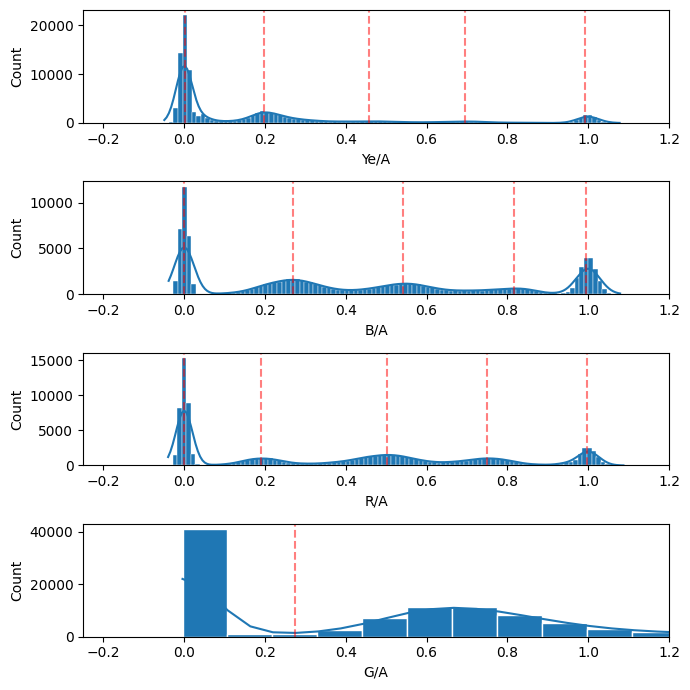

In [128]:
from scipy.signal import argrelextrema


def plot_hist_with_extrema(a, ax=None, bins=100, extrema='max', kde_kws={'bw_adjust':0.5}):
    
    sns.histplot(a, bins=bins, stat='count', edgecolor='white', alpha=1, ax=ax, kde=True, kde_kws=kde_kws)
    y = ax.get_lines()[0].get_ydata()
    if extrema == 'max':
        y = -y
    extrema = [float(_/len(y)*(max(a)-min(a))+min(a)) for _ in argrelextrema(np.array(y), np.less)[0]]
    for subextrema in extrema:
        ax.axvline(x=subextrema, color='r', alpha=0.5, linestyle='--')
    return extrema

data = intensity_fra.sample(100000)

fig, ax = plt.subplots(ncols=1, nrows=4, figsize=(7, 7))
plt.setp(ax, xlim=(-0.25, 1.2))
Y_maxima = plot_hist_with_extrema(data['Ye/A'], ax=ax[0], extrema='max', kde_kws={'bw_adjust':0.6})
B_maxima = plot_hist_with_extrema(data['B/A'], ax=ax[1], extrema='max', kde_kws={'bw_adjust':0.6})
R_maxima = plot_hist_with_extrema(data['R/A'], ax=ax[2], extrema='max', kde_kws={'bw_adjust':0.5})
G_minima = plot_hist_with_extrema(data['G/A'], ax=ax[3], extrema='min', kde_kws={'bw_adjust':1})
plt.tight_layout()
# plt.savefig(r'./dataset/PRISM64_Embryo_test/figures/output_hist.pdf', bbox_inches = 'tight', dpi=300)
# plt.savefig(r'./figures/mousebrain_hist_all.pdf', bbox_inches = 'tight')
# plt.close()
plt.show()

In [50]:
minima = G_minima.copy()
minima = minima[: G_layer - 1]  
minima.insert(0, intensity_fra['G/A'].min()-0.01)
minima.append(intensity_fra['G/A'].max()+0.01)

intensity_fra['G_layer'] = pd.cut(intensity_fra['G/A'], bins=minima, labels=[_ for _ in range(len(minima)-1)], include_lowest=True, right=False)

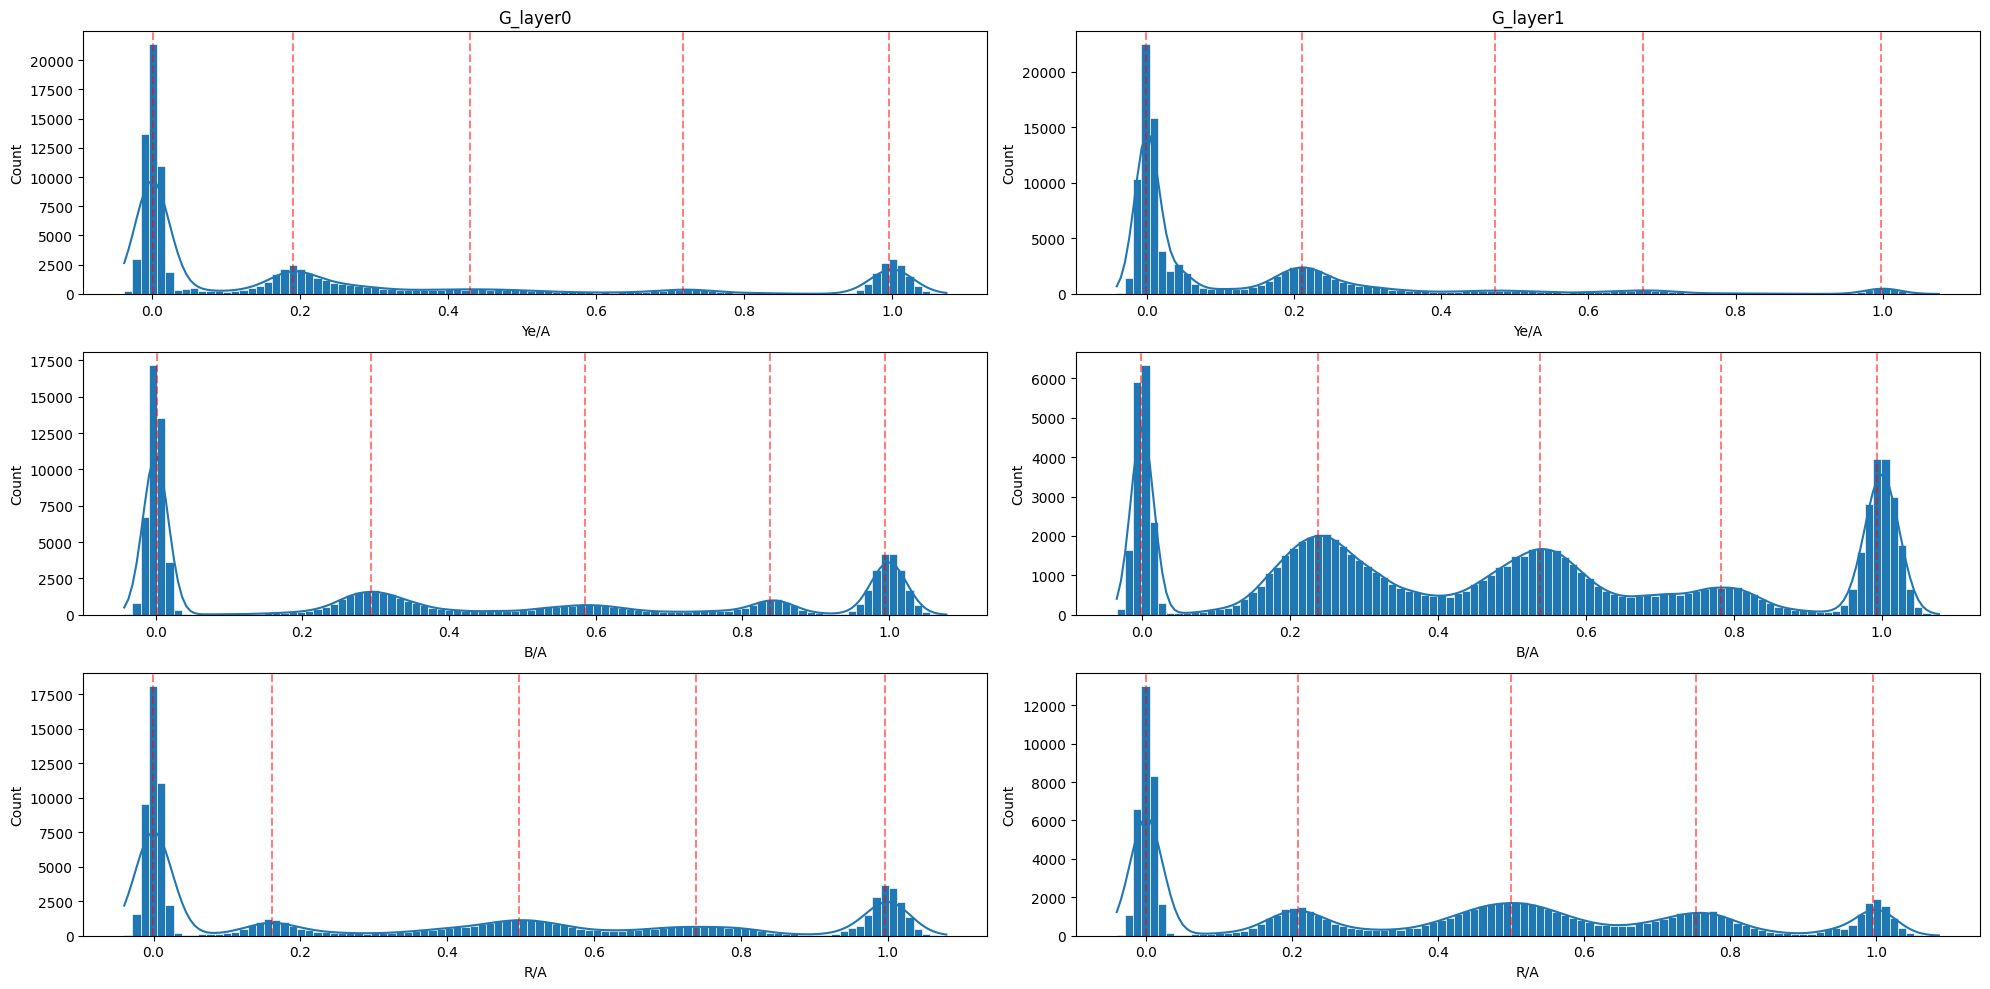

In [51]:
# preparation for init centroids
import itertools

centroid_init_dict = dict()
fig, ax =  plt.subplots(nrows=3, ncols=G_layer, figsize=(20, 10))
for layer in range(G_layer):
    data = intensity_fra[intensity_fra['G_layer'] == layer]
    data = data.sample(min(100000, len(data)))
    ax_tmp = ax if G_layer < 2 else ax[:, layer]
    ax_tmp[0].set_title(f'G_layer{layer}')
    Y_maxima_tmp = plot_hist_with_extrema(data['Ye/A'], ax=ax_tmp[0], extrema='max', kde_kws={'bw_adjust':0.6})
    B_maxima_tmp = plot_hist_with_extrema(data['B/A'], ax=ax_tmp[1], extrema='max', kde_kws={'bw_adjust':0.35})
    R_maxima_tmp = plot_hist_with_extrema(data['R/A'], ax=ax_tmp[2], extrema='max', kde_kws={'bw_adjust':0.6})

    if len(R_maxima_tmp) != color_grade:
        R_maxima_tmp = R_maxima
    if len(Y_maxima_tmp) != color_grade:
        Y_maxima_tmp = Y_maxima
    if len(B_maxima_tmp) != color_grade:
        B_maxima_tmp = B_maxima

    combinations = itertools.product(range(0, color_grade), repeat=3)
    filtered_combinations = filter(lambda x: sum(x) == color_grade - 1, combinations)
    centroid_init_dict[layer] = np.array([[Y_maxima_tmp[_[0]], B_maxima_tmp[_[1]], R_maxima_tmp[_[2]],] for _ in filtered_combinations])

plt.tight_layout()
# plt.savefig(r'./figures/mousebrain_hist_dif_layer.pdf', bbox_inches = 'tight')
# plt.savefig(r'./dataset/PRISM64_Embryo_test/figures/output_hist_by_layer.jpg', bbox_inches = 'tight', dpi=300)
# plt.savefig(r'./dataset/PRISM64_Embryo_test/figures/output_hist_by_layer.pdf', bbox_inches = 'tight', dpi=300)
# plt.close()
plt.show()

intensity_fra['label'] = [-1] * len(intensity_fra)

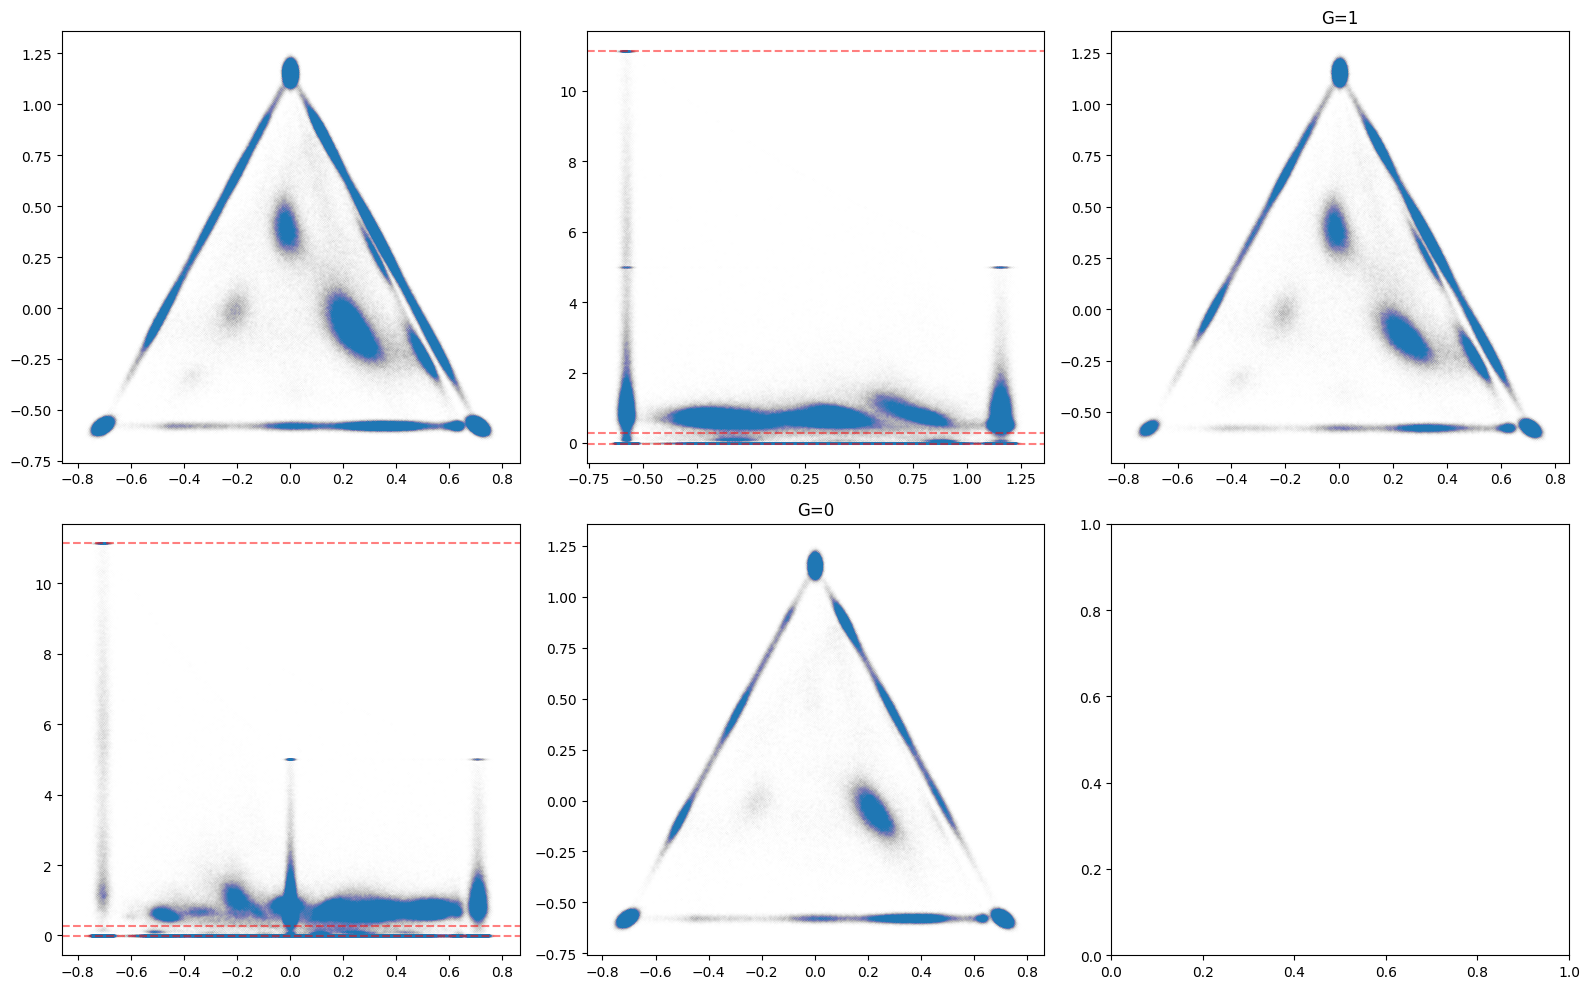

In [52]:
# intensity_fra = intensity_fra_relabel.loc[thre_index]
s = 1 / np.log2(len(intensity_fra)) * 2 /10
alpha = 1 / np.log2(len(intensity_fra)) / 3

n_rows = 2
n_cols = 2 - ( - (G_layer - 1) // 2 )

fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(5 * n_cols + 1, 10))
ax[1,0].scatter(intensity_fra['X_coor_gaussian'], intensity_fra['G/A'], s=s, alpha=alpha, linewidths=None)
ax[0,1].scatter(intensity_fra['Y_coor_gaussian'], intensity_fra['G/A'], s=s, alpha=alpha, linewidths=None)
ax[0,0].scatter(intensity_fra['X_coor_gaussian'], intensity_fra['Y_coor_gaussian'], s=s, alpha=alpha, linewidths=None)

for subextrema in minima:
    ax[1,0].axhline(y=subextrema, color='r', alpha=0.5, linestyle='--')
for subextrema in minima:
    ax[0,1].axhline(y=subextrema, color='r', alpha=0.5, linestyle='--')

for layer in range(G_layer):
    ax_tmp = ax[(1 + layer) % n_rows, 1 - (-layer // n_rows)]
    ax_tmp.set_title(f'G={layer}')
    sub = intensity_fra[intensity_fra['G_layer'] == layer]
    ax_tmp.scatter(sub['X_coor_gaussian'], sub['Y_coor_gaussian'], s=s, alpha=alpha, linewidths=None)

plt.tight_layout()
# plt.savefig(r'./dataset/PRISM64_Embryo_test/figures/distribution.jpg', bbox_inches = 'tight', dpi=300)
# plt.close()
plt.show()

## Projection of density in 3D

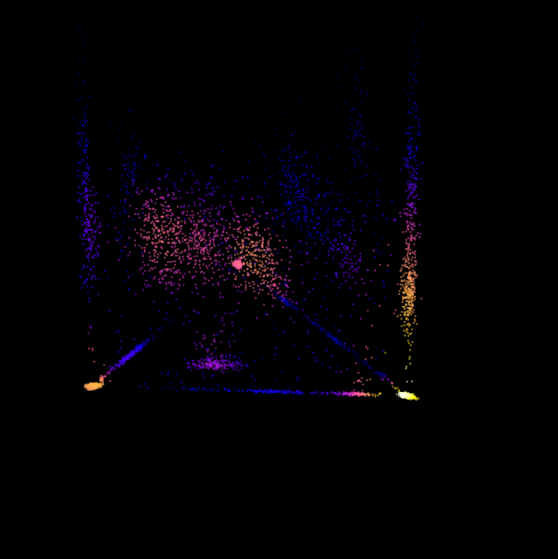

In [54]:
from scipy import stats

data = intensity_fra.sample(5000)

x = np.array(data['X_coor_gaussian'])
y = np.array(data['Y_coor_gaussian'])
z = np.array(data['G/A'])
xyz = np.vstack([x,y,z])
density = stats.gaussian_kde(xyz)(xyz) 

idx = density.argsort()
x, y, z, density = x[idx], y[idx], z[idx], density[idx]
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, 
           c=density, 
           cmap=plt.cm.gnuplot2 ,
           s=0.5,
           vmin=0,
        #    vmax=1,
           ) 
ax.set_zlim3d(-0.1,1)
ax.view_init(elev=30, azim=30)

fig.set_facecolor('black')
ax.set_facecolor('black') 
ax.grid(False) 
ax.w_xaxis.pane.fill = False
ax.w_yaxis.pane.fill = False
ax.w_zaxis.pane.fill = False
ax.set_axis_off()

# separation by GMM

In [56]:
from sklearn.mixture import GaussianMixture as GMM


def apply_gmm(reduced_features, num_clusters, means_init=None):
    gmm = GMM(n_components=num_clusters, covariance_type='diag', means_init=means_init)
    gmm_clusters = gmm.fit(reduced_features)
    labels = gmm_clusters.predict(reduced_features)
    return  gmm_clusters, labels


GMM_dict = dict()
for layer in range(G_layer):
    centroids_init = centroid_init_dict[layer]
    filtered_data = intensity_fra[intensity_fra['G_layer'] == layer]
    reduced_features = filtered_data[channel]
    gmm, gmm_labels = apply_gmm(reduced_features, num_clusters=len(centroids_init), means_init=centroids_init)
    GMM_dict[layer] = gmm 
    intensity_fra.loc[filtered_data.index, 'label'] = gmm_labels + int(layer * num_per_layer + 1)

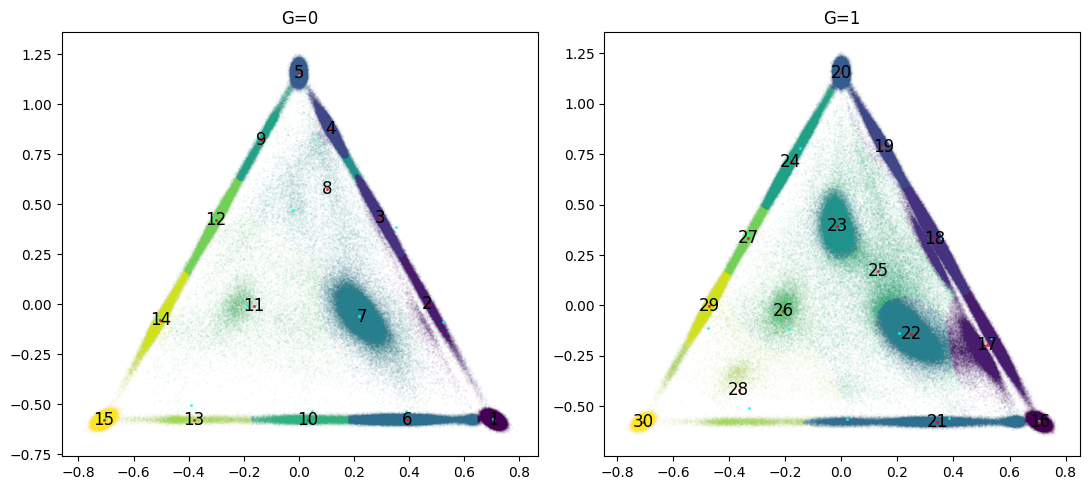

In [57]:
fig, ax = plt.subplots(nrows=1, ncols=G_layer, figsize=(5.5 * G_layer, 5))
for layer in range(G_layer):
    ax_tmp = ax if G_layer < 2 else ax[layer]

    data = intensity_fra[intensity_fra['G_layer'] == layer]
    data = data[data['label'] != -1]
    gmm = GMM_dict[layer]
    
    ax_tmp.scatter(data['X_coor_gaussian'], data['Y_coor_gaussian'], c=data['label'], marker='.', alpha=0.1, s=0.1)
    centroids = gmm.means_ @ RYB_xy_transform
    
    centroid_init = centroid_init_dict[layer] @ RYB_xy_transform
    ax_tmp.scatter(centroid_init[:, 0], centroid_init[:, 1], color='cyan', s=1.5, alpha=0.7)
    
    for i, centroid in enumerate(centroids):
        ax_tmp.text(centroid[0], centroid[1], i + int(layer * num_per_layer + 1), fontsize=12, color='black', ha='center', va='center')
    ax_tmp.scatter(centroids[:, 0], centroids[:, 1], color='r', s=1.5, alpha=0.7)
    # ax_tmp.set_xlim([-1, 1])
    # ax_tmp.set_ylim([-0.6, 0.6])
    
    ax_tmp.set_title(f'G={layer}')

plt.tight_layout()
# plt.savefig(r'./dataset/PRISM30_mousebrain/figures//mousebrain_scatter_GMM_cluster_by_layer.jpg', bbox_inches = 'tight', dpi=300)
plt.show()

# for i, ax in enumerate(ax.flat):
#     ax.set_xticks([])
#     ax.set_yticks([])
#     ax.set_xlabel('')
#     ax.set_ylabel('')
#     ax.set_title('')
#     bbox = ax.get_tightbbox(fig.canvas.get_renderer())
#     bbox = bbox.transformed(fig.dpi_scale_trans.inverted())

#     plt.savefig(rf'./dataset/PRISM30_mousebrain/figures/layer{i+1}.jpg', bbox_inches=bbox)

# plt.close(fig)

In [60]:
intensity.to_csv(r'E:\TMC\PRISM_pipeline\dataset\processed\_example_dataset_processed\readout\intensity_scaled.csv')

## mannual revise using mask

In [739]:
import cv2
def relabel_mask(intensity, plot_column=['X_coor_gaussian', 'Y_coor_gaussian'], 
                 mask=np.array, ori_label=int, ch_label=int, 
                 xlim=(-1,1), ylim=(-1,1.5),
                 replace=False,):
    
    x, y = mask.shape[0], mask.shape[1]
    if not replace:
        data = intensity[intensity['label']==ori_label]
        data['label'] = [-1] * len(data)
    else:
        data = intensity.copy()
    data['x'] = (ylim[1] - data[plot_column[1]]) * x / (ylim[1]  - ylim[0])
    data['y'] = (data[plot_column[0]]- xlim[0] ) * y / (xlim[1]  - xlim[0])
    
    for index, row in tqdm(data.iterrows(), desc=f'relabel{ori_label}'):
        if mask[int(row['x']), int(row['y'])]:
            data.at[index, 'label'] = ch_label
    
    intensity.loc[data.index, 'label'] = data['label']
    intensity = intensity[intensity['label']!=-1]

    return intensity

In [747]:
relabel = [11,22]
for label in relabel:
    mask = cv2.imread(f'./dataset/PRISM30_mousebrain/masks/mask_{label}.png', cv2.IMREAD_GRAYSCALE)
    intensity_fra_relabel = relabel_mask(intensity_fra, mask=mask, ori_label=label, ch_label=label, replace=False)

relabel11: 4620it [00:00, 18266.12it/s]
relabel22: 9449it [00:00, 18622.12it/s]


## relabel of data

In [5]:
intensity_raw = pd.read_csv(read_dir/'intensity_deduplicated.csv', index_col=0)
intensity_fra_relabel = pd.read_csv(read_dir/'intensity_labeled.csv', index_col=0)

In [6]:
# relabel_1 = {1:1, 7:2, 12:3, 16:4, 19:5, 21:6, 20:7, 18:8, 15:9, 11:10, 6:11, 5:12, 4:13, 3:14, 2:15, 8:16, 13:17, 9:18, 17:19, 14:20, 10:21}
relabel_1 = {1:1,6:2,10:3,13:4,15:5,14:6,12:7,9:8,5:9,4:10,3:11,2:12,7:13,11:14,8:15,}
relabel = {key:value for key, value in relabel_1.items()}
for ori_label in relabel_1.keys():
    relabel[ori_label+15] = relabel_1[ori_label] + 15
    # relabel[ori_label+21] = relabel_1[ori_label] + 21
    # relabel[ori_label+42] = relabel_1[ori_label] + 42

In [7]:
intensity_fra_relabel['label'] = intensity_fra_relabel['label'].replace(relabel)

# Quantitative analysis of GMM cluster quality

## cluster points num distribution

In [10]:
data = intensity_fra_relabel.copy()
plt.figure(figsize=(num_per_layer * G_layer / 3, 5))
sns.barplot(x = [cluster_num + 1 for cluster_num in range(num_per_layer * G_layer)], 
            y = [len(data[data['label']==cluster_num+1]) for cluster_num in range(num_per_layer * G_layer)],
            )
# plt.savefig(r'./figures/mousebrain_hist_cluster_num_distribution.pdf', bbox_inches = 'tight')
plt.show()

NameError: name 'num_per_layer' is not defined

## cdf related analysis

In [140]:
from tqdm import tqdm
from scipy import stats
import numpy as np


def calculate_cdf_gmm(X_sub, gmm, st):
    X_sub_cal = X_sub[['Ye/A', 'B/A', 'R/A',]]
    # Get the of each cluster
    cdfs_df = pd.DataFrame()

    for i in tqdm(range(gmm.n_components), desc='component'):
        if gmm.covariance_type == 'tied':
            mean = gmm.means_[i]
            cov = gmm.covariances_
        elif gmm.covariance_type == 'diag':
            mean = gmm.means_[i]
            cov = np.diag(gmm.covariances_[i])

        m_dist_x = (X_sub_cal-mean) @ np.linalg.inv(cov)
        m_dist_x = np.einsum('ij,ji->i', m_dist_x, (X_sub_cal-mean).T)

        probability = 1 - stats.chi2.cdf(np.array(m_dist_x), 3)
        cdfs_df[i + 1 + st] = probability
        
    cdfs_df.index = X_sub.index

    return cdfs_df


def calculate_cdf_mannual(intensity, st, num_per_layer, channel=['Ye/A', 'B/A', 'R/A',]):
    centroids = []
    cdfs_df = pd.DataFrame()
    for i in tqdm(range(st + 1, st + num_per_layer + 1), desc='component'):
        data_cdf = intensity[channel]
        data = intensity[intensity['label'] == i]
        data = data[channel]
        points = np.array(data)
        
        # calculate the mean
        mean = np.mean(points, axis=0)

        # calculate the covariance matrix
        cov = np.cov(points, rowvar=False)

        # calculate cdf
        m_dist_x = (data_cdf - mean) @ np.linalg.pinv(cov)
        m_dist_x = np.einsum('ij,ji->i', m_dist_x, (data_cdf - mean).T)
        probability = 1 - stats.chi2.cdf(np.array(m_dist_x), len(channel))
        cdfs_df[i] = probability
        centroids.append(mean)
    centroids = np.array(centroids)
    cdfs_df.index = intensity.index

    return cdfs_df, centroids

### cdf-3d and separate by layer

In [ ]:
CDF_dict = dict()
for layer in range(G_layer):
    X = intensity_fra[intensity_fra['G_layer'] == layer]
    X_sub = X.copy()
    CDF_dict[layer] = calculate_cdf_gmm(X_sub, GMM_dict[layer], st=layer * num_per_layer)

In [ ]:
data = intensity_fra_relabel[intensity_fra_relabel['label'] != -1]
CDF_dict = dict()
for layer in range(G_layer):
    CDF_dict[layer]= calculate_cdf_mannual(data, st=layer * num_per_layer, num_per_layer=num_per_layer)

#### cdf distribution overall

In [ ]:
for layer in range(G_layer):
   cdf_data = CDF_dict[layer]
   ax_tmp = ax if G_layer < 2 else ax[layer]
   cm = sns.clustermap(cdf_data.sample(1000), figsize=(5, 4), metric='euclidean',
                     method='ward', 
                     col_cluster=False,
                     )
   cm.ax_heatmap.set(yticks=[],)
   cm.fig.suptitle(f'layer={layer}')

#### cluster relationship evaluation by heatmap

In [ ]:
p_thre_list = [0.0001, 0.001, 0.01, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5]
corr_method = 'spearman'
intensity_data = intensity_fra_relabel.copy()

fig, ax = plt.subplots(nrows=G_layer, ncols=len(p_thre_list) + 1, figsize=(6 * (len(p_thre_list)+1) , 5 * G_layer))
for layer in tqdm(range(G_layer)):
    cdfs_df = CDF_dict[layer]
    X_sub = intensity_data[intensity_data['G_layer'] == layer]
    ax_heat = ax[layer, -1] if G_layer > 1 else ax[-1]
    
    corr_matrix = cdfs_df.corr(method=corr_method)
    sns.heatmap(corr_matrix, 
                ax=ax_heat, 
                cmap='coolwarm',
                )
    
    ax_heat.set_title(f'{corr_method}_correlation')

    for _, p_thre in enumerate(p_thre_list):
        overlap = pd.DataFrame()

        for cluster_num in range(layer * num_per_layer + 1, (layer + 1) * num_per_layer + 1):
            tmp = cdfs_df.loc[X_sub['label'][X_sub['label']==(cluster_num)].index]
            overlap[cluster_num] = (tmp>p_thre).sum(axis=0)/len(tmp)

        ax_tmp = ax[layer, _] if len(p_thre_list) > 1 and G_layer > 1 else ax[layer] if G_layer > 1 else ax[_] if len(p_thre_list) > 1 else ax
        ax_tmp.set_title(f'p_thre = {p_thre}')
        if _ == 0:
            ax_tmp.set_ylabel(f'G={layer}', fontsize=16)

        sns.heatmap(overlap, vmin=0, vmax=1, ax=ax_tmp)

plt.tight_layout()
plt.show()

#### overall separation evaluation by entropy

In [ ]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score
from scipy.stats import entropy


sample=20
p_thre_list = [_/sample for _ in range(sample)]
# p_thre_list = [0.1]
near_list = []
en_list = []

data = intensity_fra_relabel.copy()

for thre in tqdm(p_thre_list):
    thre_index = []
    for layer in range(G_layer):
        cdfs_df = CDF_dict[layer]
        X_sub = data[data['G_layer'] == layer]
        for cluster_num in range(layer*num_per_layer+1, (layer+1)*num_per_layer+1):
            tmp = cdfs_df.loc[X_sub['label'][X_sub['label']==(cluster_num)].index]
            tmp = tmp[tmp[cluster_num]>thre]
            thre_index += list(tmp.index)

    thre_index.sort()
    thre_index = pd.Index(thre_index)
    tmp1 = intensity_fra.loc[thre_index]
    

    score = []
    en  = []
    for layer in range(G_layer):
        cdfs_df = CDF_dict[layer]
        tmp = tmp1[tmp1['G_layer']==layer]
        tmp_index = tmp.index
        tmp_cdf = cdfs_df.loc[tmp_index].sample(min(20000, len(tmp_index)))
        tmp_cdf_sum = tmp_cdf.sum(axis=1)
        tmp_cdf_cal = tmp_cdf.div(tmp_cdf_sum, axis=0)

        score.append(davies_bouldin_score(tmp[channel], tmp['label']))
        en.append(np.mean([entropy(tmp_cdf_cal.iloc[i]) / np.log(num_per_layer) / np.sqrt(tmp_cdf_sum.iloc[i]) for i in range(len(tmp_cdf_cal))]))
    
    en_list.append(en)
    near_list.append(score)

near_list = np.array(near_list)
en_list = np.array(en_list)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Create data
p_thre_list = [_/sample for _ in range(sample)]
x = p_thre_list
y1 = en_list[:,0]  # Data for the first y-axis
y2 = en_list[:,1]  # Data for the second y-axis
# y3 = en_list[:,2]  # Data for the second y-axis

# Create a figure and a primary axes
fig, ax1 = plt.subplots()

# Plot the first dataset on primary axes
ax1.plot(x, y1, 'b-')
ax1.set_xlabel('P_thre')
ax1.set_ylabel('Entropy_0', color='b')
ax1.tick_params('y', colors='b')

# Create and plot on the secondary axes
ax2 = ax1.twinx()
ax2.plot(x, y2, 'r-')
ax2.set_ylabel('Entropy_1', color='r')
ax2.tick_params('y', colors='r')

# Create and plot on the third axes
# ax3 = ax1.twinx()
# ax3.spines['right'].set_position(('outward', 60))  # Offset the right spine
# ax3.plot(x, y3, 'g-')
# ax3.set_ylabel('Entropy_2', color='g')
# ax3.tick_params('y', colors='g')

plt.title("Entropy")
plt.show()


### cdf_4d

#### calculation

In [141]:
total_num = 30
cdf_4d, centroids = calculate_cdf_mannual(intensity_fra_relabel[intensity_fra_relabel['label']!=-1], st=0, num_per_layer=total_num, channel=['Ye/A', 'B/A', 'R/A', 'G/A'])

component: 100%|██████████| 30/30 [00:11<00:00,  2.56it/s]


#### evaluation

p_thre: 12it [00:15,  1.27s/it]


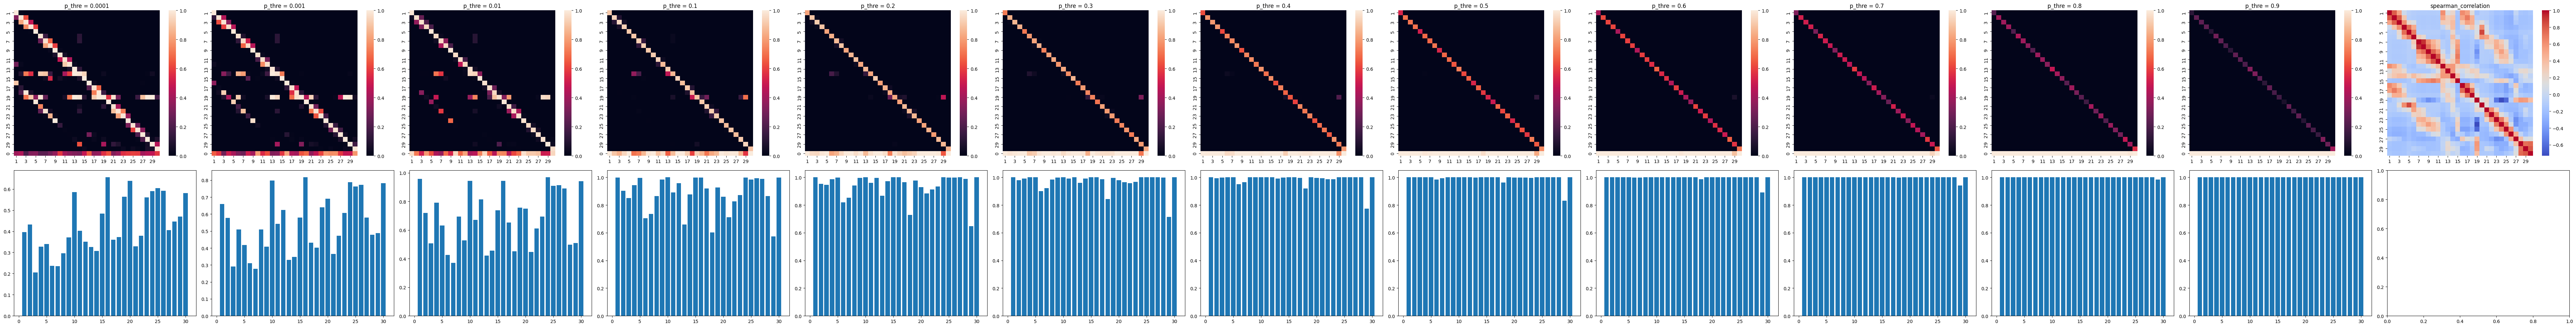

In [142]:
p_thre_list = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
accuracy = []
corr_method = 'spearman'
intensity_data = intensity_fra_relabel.copy()

fig, ax = plt.subplots(nrows=2, ncols=len(p_thre_list) + 1, figsize=(6 * (len(p_thre_list)+1) , 5 * 2))

cdfs_df = cdf_4d.copy()
X_sub = intensity_data.copy()
ax_heat = ax[0, -1]

corr_matrix = cdfs_df.corr(method=corr_method)
sns.heatmap(corr_matrix, 
            ax=ax_heat, 
            cmap='coolwarm',
            )

ax_heat.set_title(f'{corr_method}_correlation')

for _, p_thre in tqdm(enumerate(p_thre_list), desc='p_thre'):
    overlap = pd.DataFrame()

    for cluster_num in range(1, total_num+1):
        tmp = cdfs_df.loc[X_sub['label'][X_sub['label']==(cluster_num)].index]
        overlap[cluster_num] = (tmp>p_thre).sum(axis=0)/len(tmp)
        
    add = np.diag(overlap) / overlap.sum(axis=0)
    ax[1, _].bar(add.index, add.values)
    accuracy.append(np.mean(add))
    overlap = pd.concat([overlap, pd.DataFrame(add).T], axis=0)

    ax_tmp = ax[0, _]
    ax_tmp.set_title(f'p_thre = {p_thre}')

    sns.heatmap(overlap, vmin=0, vmax=1, ax=ax_tmp)

plt.tight_layout()
# plt.savefig(r'./dataset/PRISM30_mousebrain/figures/output_coor.pdf', bbox_inches = 'tight')

plt.show()

In [143]:
sample = 100
p_thre_list = [_/sample for _ in range(sample)]
accuracy = []

for _, p_thre in tqdm(enumerate(p_thre_list), desc='p_thre'):
    overlap = pd.DataFrame()

    for cluster_num in range(1, total_num+1):
        tmp = cdfs_df.loc[X_sub['label'][X_sub['label']==(cluster_num)].index]
        overlap[cluster_num] = (tmp>p_thre).sum(axis=0)/len(tmp)
    add = np.diag(overlap) / overlap.sum(axis=1)
    accuracy.append(add)
    overlap = pd.concat([overlap, pd.DataFrame(add).T], axis=0)

accuracy = np.array(accuracy)

p_thre: 100it [01:04,  1.54it/s]


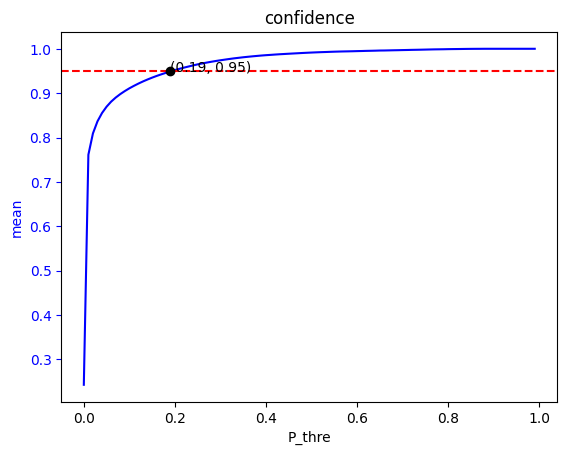

In [144]:
import matplotlib.pyplot as plt
import numpy as np

# Create data
x = p_thre_list
y1 = np.mean(accuracy,axis=1)  # Data for the first y-axis
# y2 = np.percentile(accuracy, q=50, axis=1)  # Data for the second y-axis
# y3 = en_list[:,2]  # Data for the second y-axis

y_line = 0.95

indices = np.where(np.diff(np.sign(y1 - y_line)))[0][0]
x_intercepts = x[indices]
y_intercepts = y1[indices]

# Create a figure and a primary axes
fig, ax1 = plt.subplots()


# Plot the first dataset on primary axes
ax1.plot(x, y1, 'b-')
ax1.set_xlabel('P_thre')
ax1.set_ylabel('mean', color='b')
ax1.tick_params('y', colors='b')

ax1.axhline(y_line, color='r', linestyle='--', label=f'y = {y_line}')
for x_i, y_i in zip([x_intercepts], [y_intercepts]):
    plt.plot(x_i, y_i, 'ko')
    plt.text(x_i, y_i, f'({x_i:.2f}, {y_i:.2f})')

# Create and plot on the secondary axes
# ax2 = ax1.twinx()
# ax2.plot(x, y2, 'r-')
# ax2.set_ylabel('percentile', color='r')
# ax2.tick_params('y', colors='r')

# Create and plot on the third axes
# ax3 = ax1.twinx()
# ax3.spines['right'].set_position(('outward', 60))  # Offset the right spine
# ax3.plot(x, y3, 'g-')
# ax3.set_ylabel('Entropy_2', color='g')
# ax3.tick_params('y', colors='g')

plt.title("confidence")

# plt.savefig(r'E:\TMC\PRISM_point_typing\dataset\PRISM64_Embryo_test\figures\output_confidence.pdf', bbox_inches = 'tight')
plt.show()

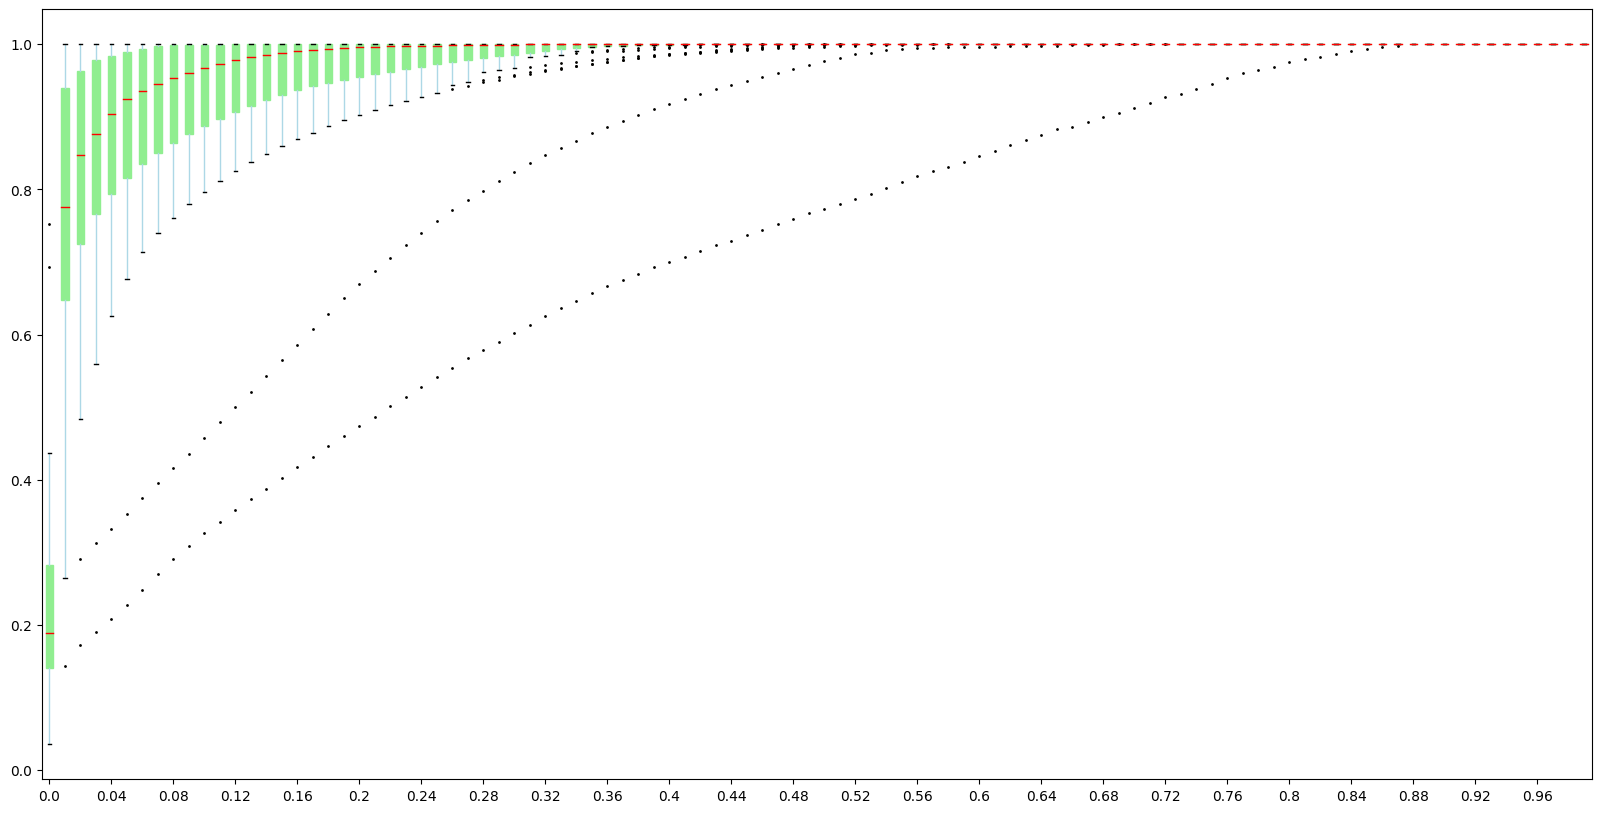

In [145]:
boxprops = dict(facecolor='lightgreen', color='lightgreen')  # Properties for the box
whiskerprops = dict(color='lightblue')  # Properties for the whiskers
capprops = dict(color='black')  # Properties for the caps on the whiskers
medianprops = dict(color='red')  # Properties for the median line
flierprops = dict(marker='.', markerfacecolor='orange', markersize=2, linestyle='none')  # Properties for the outliers

fig, ax = plt.subplots(figsize=(20,10))
plt.boxplot(accuracy.T, patch_artist=True, boxprops=boxprops, whiskerprops=whiskerprops, 
            capprops=capprops, medianprops=medianprops, flierprops=flierprops)
step = 4
plt.xticks([_+1 for _ in range(0, len(p_thre_list), step)], [p_thre_list[_] for _ in range(0, len(p_thre_list), step)])
# plt.savefig(r'./dataset/PRISM64_Embryo_test/figures/output_accuracy.pdf', bbox_inches = 'tight', dpi=300)

plt.show()

### entropy evaluation

#### entropy evaluation

In [ ]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score
from scipy.stats import entropy


tmp_channel = ['Ye/A', 'B/A', 'R/A', 'G/A']

tick = 20
p_thre_list_4d = [0.01+_/tick for _ in range(tick)]
# p_thre_list = [0.1]

score_4d = []
entropy_detail = []

for thre in tqdm(p_thre_list_4d):
    thre_index = []
    data = intensity_fra.copy()
    cdfs_df = cdf_4d.copy()
    for cluster_num in range(1, total_num+1):
        tmp = cdfs_df.loc[data['label'][data['label']==(cluster_num)].index]
        tmp = tmp[tmp[cluster_num]>thre]
        thre_index += list(tmp.index)

    thre_index.sort()
    thre_index = pd.Index(thre_index)
    tmp = intensity_fra.loc[thre_index]
    tmp_cdf = cdfs_df.loc[thre_index].sample(min(20000, len(thre_index)))
    tmp_cdf_sum = tmp_cdf.sum(axis=1)
    tmp_cdf_cal = tmp_cdf.div(tmp_cdf_sum, axis=0)

    entropy_list = [entropy(tmp_cdf_cal.iloc[i]) / np.log(63) / tmp_cdf_sum.iloc[i] for i in range(len(tmp_cdf_cal))]
    score_4d.append(davies_bouldin_score(tmp[tmp_channel], tmp['label'])) 
    entropy_detail.append(entropy_list)
score_4d = np.array(score_4d)

In [ ]:
import matplotlib.pyplot as plt

# Sample data
x = p_thre_list_4d
# y1 = en_4d  # Data for the first y-axis
# y2 = score_4d  # Data for the second y-axis
# y3 = [np.percentile(np.array(sorted(entropy_detail[_])), 99) for _ in range(len(entropy_detail))]
y1 = [np.percentile(entropy_detail[_], 100) for _ in range(len(entropy_detail))]
y2 = [np.percentile(entropy_detail[_], 99) for _ in range(len(entropy_detail))]
y3 = [np.percentile(entropy_detail[_], 95) for _ in range(len(entropy_detail))]
y4 = [np.percentile(entropy_detail[_], 90) for _ in range(len(entropy_detail))]
y5 = [np.mean(entropy_detail[_]) for _ in range(len(entropy_detail))]


# Create a figure and a set of subplots
fig, ax1 = plt.subplots()

# Plot the first line
color = 'tab:red'
ax1.set_xlabel('p_thre')
ax1.set_ylabel('Entropy_max', color=color)
ax1.plot(x, y1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Instantiate a second y-axis sharing the same x-axis
ax2 = ax1.twinx()  
color = 'orange'
ax2.set_ylabel('Entropy_0.99', color=color)
ax2.plot(x, y2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Create and plot on the third axes
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))  # Offset the right spine
ax3.plot(x, y3, 'g-')
ax3.set_ylabel('Entropy_0.95', color='g')
ax3.tick_params('y', colors='g')

# Create and plot on the third axes
ax4 = ax1.twinx()
color = 'tab:blue'
ax4.spines['right'].set_position(('outward', 120))  # Offset the right spine
ax4.plot(x, y4, color=color)
ax4.set_ylabel('Entropy_0.90', color=color)
ax4.tick_params(axis='y', labelcolor=color)

# Create and plot on the third axes
ax4 = ax1.twinx()
color = 'purple'
ax4.spines['right'].set_position(('outward', 180))  # Offset the right spine
ax4.plot(x, y5, color=color)
ax4.set_ylabel('Entropy_mean', color=color)
ax4.tick_params(axis='y', labelcolor=color)

# Show the plot
plt.title('Quality by p_thre')
plt.show()

#### entropy evaluation by simulation data

In [ ]:
centroids_si = []
color_maxima = [_/(color_grade-1) for _ in range(color_grade)]
color_tmp = [_/color_grade for _ in range(color_grade)]
for layer in range(3):
    combinations = itertools.product(range(0, color_grade), repeat=3)
    filtered_combinations = filter(lambda x: sum(x) == color_grade - 1, combinations)
    centroids_si += [[color_maxima[_[0]], color_maxima[_[1]], color_maxima[_[2]], 0.8*layer/(G_layer-1)] for _ in filtered_combinations]

In [ ]:
def generate_gaussian(centroids, cov, channel, sample=1000):
    """
    generate random points of the same dimension of centroids in several
    gaussian distributions(the distribution number is the same as the number of centroids)
    at the centroids with covariance matrix cov, and points of one distribution is marked.
    """
    intensity_simu = pd.DataFrame()
    for _, centroid in enumerate(centroids):
        # generate random points of the same dimension of centroids
        points = np.random.multivariate_normal(centroid, cov, sample)
        label = np.array([[int(_+1)] for j in range(sample)])
        add_data = np.concatenate([points, label], axis=1)
        add_df = pd.DataFrame(data=add_data, columns=channel+['label'])
        intensity_simu = pd.concat([intensity_simu, add_df])
    return intensity_simu

In [ ]:
intensity_simu = generate_gaussian(centroids=centroids_si, cov=np.diag([0.002]*3+[0.005]), channel=['Ye/A', 'B/A', 'R/A', 'G/A'], sample=1000)
intensity_simu['X_coor_gaussian'] = intensity_simu[channel].dot(RYB_x_transform)
intensity_simu['Y_coor_gaussian'] = intensity_simu[channel].dot(RYB_y_transform)
intensity_simu.index = [_ for _ in range(len(intensity_simu))]

In [ ]:
from scipy import stats

data = intensity_simu.copy()
data = data.sample(5000)

x = np.array(data['X_coor_gaussian'])
y = np.array(data['Y_coor_gaussian'])
z = np.array(data['G/A'])
xyz = np.vstack([x,y,z])
density = stats.gaussian_kde(xyz)(xyz) 

idx = density.argsort()
x, y, z, density = x[idx], y[idx], z[idx], density[idx]
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, 
           c=density, 
           cmap=plt.cm.gnuplot2 ,
           s=0.1,
           vmin=0,
          #  vmax=1,
           ) 
ax.set_zlim3d(-0.1,1)
ax.view_init(elev=90, azim=30)

fig.set_facecolor('black')
ax.set_facecolor('black') 
ax.grid(False) 
ax.w_xaxis.pane.fill = False
ax.w_yaxis.pane.fill = False
ax.w_zaxis.pane.fill = False
ax.set_axis_off()

In [ ]:
total_num = 63
cdf_simu = calculate_cdf_mannual(intensity_simu, st=0, num_per_layer=total_num, channel=['Ye/A', 'B/A', 'R/A', 'G/A'])

cdfs_df = cdf_simu.copy()
X_sub = intensity_simu.copy()
corr_method = 'spearman'
p_thre_list = [0.0001, 0.001, 0.01, 0.1,]

fig, ax = plt.subplots(nrows=1, ncols=len(p_thre_list) + 1, figsize=(6 * (len(p_thre_list)+1) , 5 * 1))

ax_heat = ax[-1]
corr_matrix = cdfs_df.corr(method=corr_method)
sns.heatmap(corr_matrix,ax=ax_heat, cmap='coolwarm')
ax_heat.set_title(f'{corr_method}_correlation')

for _, p_thre in tqdm(enumerate(p_thre_list), desc='p_thre'):
    overlap = pd.DataFrame()
    for cluster_num in range(1, total_num+1):
        tmp = cdfs_df.loc[X_sub['label'][X_sub['label']==(cluster_num)].index]
        overlap[cluster_num] = (tmp>p_thre).sum(axis=0)/len(tmp)
    ax_tmp = ax[_]
    ax_tmp.set_title(f'p_thre = {p_thre}')
    sns.heatmap(overlap, vmin=0, vmax=1, ax=ax_tmp)

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score
from scipy.stats import entropy


tmp_channel = ['Ye/A', 'B/A', 'R/A', 'G/A']

tick = 20
p_thre_list_4d = [0.01+_/tick for _ in range(tick)]
# p_thre_list = [0.1]

score_4d = []
entropy_detail = []

for thre in tqdm(p_thre_list_4d):
    thre_index = []
    data = intensity_simu.copy()
    cdfs_df = cdf_simu.copy()
    for cluster_num in range(1, total_num+1):
        tmp = cdfs_df.loc[data['label'][data['label']==(cluster_num)].index]
        tmp = tmp[tmp[cluster_num]>thre]
        thre_index += list(tmp.index)

    thre_index.sort()
    thre_index = pd.Index(thre_index)
    tmp = intensity_simu.loc[thre_index]
    tmp_cdf = cdfs_df.loc[thre_index].sample(min(20000, len(thre_index)))
    tmp_cdf_sum = tmp_cdf.sum(axis=1)
    tmp_cdf_cal = tmp_cdf.div(tmp_cdf_sum, axis=0)

    entropy_list = [entropy(tmp_cdf_cal.iloc[i]) / np.log(63) / tmp_cdf_sum.iloc[i] for i in range(len(tmp_cdf_cal))]
    score_4d.append(davies_bouldin_score(tmp[tmp_channel], tmp['label'])) 
    entropy_detail.append(entropy_list)
score_4d = np.array(score_4d)

In [ ]:
import matplotlib.pyplot as plt

# Sample data
x = p_thre_list_4d
# y1 = en_4d  # Data for the first y-axis
# y2 = score_4d  # Data for the second y-axis
# y3 = [np.percentile(np.array(sorted(entropy_detail[_])), 99) for _ in range(len(entropy_detail))]
y1 = [np.percentile(entropy_detail[_], 100) for _ in range(len(entropy_detail))]
y2 = [np.percentile(entropy_detail[_], 99) for _ in range(len(entropy_detail))]
y3 = [np.percentile(entropy_detail[_], 95) for _ in range(len(entropy_detail))]
y4 = [np.percentile(entropy_detail[_], 90) for _ in range(len(entropy_detail))]
y5 = [np.mean(entropy_detail[_]) for _ in range(len(entropy_detail))]


# Create a figure and a set of subplots
fig, ax1 = plt.subplots()

# Plot the first line
color = 'tab:red'
ax1.set_xlabel('p_thre')
ax1.set_ylabel('Entropy_max', color=color)
ax1.plot(x, y1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Instantiate a second y-axis sharing the same x-axis
ax2 = ax1.twinx()  
color = 'orange'
ax2.set_ylabel('Entropy_0.99', color=color)
ax2.plot(x, y2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Create and plot on the third axes
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))  # Offset the right spine
ax3.plot(x, y3, 'g-')
ax3.set_ylabel('Entropy_0.95', color='g')
ax3.tick_params('y', colors='g')

# Create and plot on the third axes
ax4 = ax1.twinx()
color = 'tab:blue'
ax4.spines['right'].set_position(('outward', 120))  # Offset the right spine
ax4.plot(x, y4, color=color)
ax4.set_ylabel('Entropy_0.90', color=color)
ax4.tick_params(axis='y', labelcolor=color)

# Create and plot on the third axes
ax4 = ax1.twinx()
color = 'purple'
ax4.spines['right'].set_position(('outward', 180))  # Offset the right spine
ax4.plot(x, y5, color=color)
ax4.set_ylabel('Entropy_mean', color=color)
ax4.tick_params(axis='y', labelcolor=color)

# Show the plot
plt.title('Quality by p_thre')
plt.show()

# cluster visulization after threshold

In [366]:
workdir = r'E:\TMC\PRISM_point_typing\dataset\20231221_PRISM64_Embryo_real'

In [146]:
def visualization(intensity_fra,
                  G_layer=3,
                  num_per_layer=21,
                  bins = [100, 100],
                  percentile_thre=90,
                  out_path_dir=None,):
    
    s = 1 / np.log2(len(intensity_fra)) *5
    alpha = 1 / np.log2(len(intensity_fra)) 

    fig, ax = plt.subplots(nrows=2, ncols=G_layer, figsize=(5.5 * G_layer, 10))
    for layer in tqdm(range(G_layer)):
        data = intensity_fra[intensity_fra['G_layer'] == layer]
        x, y = data['X_coor_gaussian'], data['Y_coor_gaussian']
        ax_scatter = ax[0] if G_layer < 2 else ax[0, layer]
        ax_scatter.scatter(data['X_coor_gaussian'], data['Y_coor_gaussian'], c=data['label'], marker='.', alpha=alpha, s=s)
        
        for i in range(1 + layer * num_per_layer, 1 + (layer+1) * num_per_layer):
            data_tmp = data[data['label']==i]
            cen_tmp = np.mean(data_tmp[['X_coor_gaussian', 'Y_coor_gaussian']], axis=0)
            ax_scatter.text(cen_tmp[0], cen_tmp[1], i, fontsize=12, color='black', ha='center', va='center')

        ax_scatter.set_title(f'G={layer}')


        ax_density = ax[1] if G_layer < 2 else ax[1, layer]
        hist, xedges, yedges = np.histogram2d(x, y, bins=bins)
        percentile = np.percentile(hist, percentile_thre)
        ax_density.hist2d(x, y, bins=bins, vmax=percentile)
        
    plt.tight_layout()
    if out_path_dir == None: plt.show()
    else: plt.savefig(out_path_dir, bbox_inches = 'tight')

## data preprocess

In [147]:
RYB_x_transform_ = np.array([[-np.sqrt(2)/2], [np.sqrt(2)/2], [0]])
RYB_y_transform_ = np.array([[-1/2], [-1/2], [np.sqrt(2)/4]])

intensity_fra_relabel_xy_transformed = intensity_fra_relabel.copy()
intensity_fra_relabel_xy_transformed['X_coor_gaussian'] = intensity_fra_relabel_xy_transformed[channel] @ RYB_x_transform_
intensity_fra_relabel_xy_transformed['Y_coor_gaussian'] = intensity_fra_relabel_xy_transformed[channel] @ RYB_y_transform_

intensity_raw['X_coor_gaussian'] = intensity_raw[channel] @ RYB_x_transform_
intensity_raw['Y_coor_gaussian'] = intensity_raw[channel] @ RYB_y_transform_

## visualization of raw data

In [ ]:
# intensity_raw

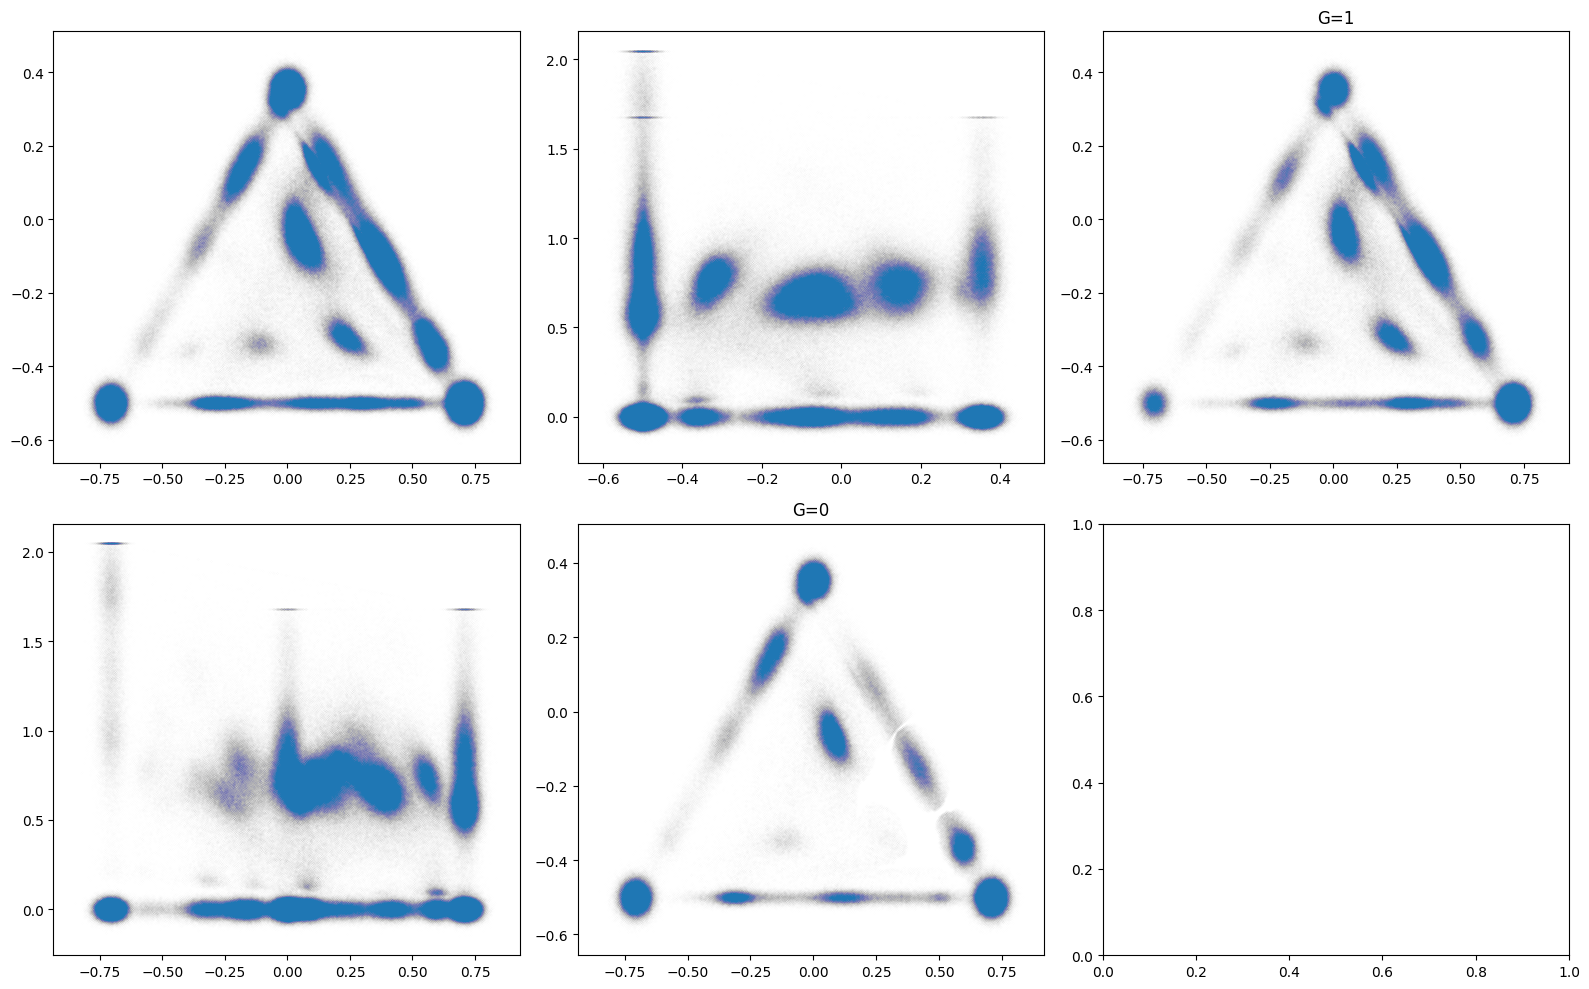

In [73]:
data = intensity_fra_relabel_xy_transformed
s = 1 / np.log2(len(data)) * 2 / 10
alpha = 1 / np.log2(len(data)) / 3

n_rows = 2
n_cols = 2 - ( - (G_layer - 1) // 2 )

fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(5 * n_cols + 1, 10))
ax[1,0].scatter(data['X_coor_gaussian'], data['G/A'], s=s, alpha=alpha, linewidths=None)
ax[0,1].scatter(data['Y_coor_gaussian'], data['G/A'], s=s, alpha=alpha, linewidths=None)
ax[0,0].scatter(data['X_coor_gaussian'], data['Y_coor_gaussian'], s=s, alpha=alpha, linewidths=None)

for layer in range(G_layer):
    ax_tmp = ax[(1 + layer) % n_rows, 1 - (-layer // n_rows)]
    ax_tmp.set_title(f'G={layer}')
    sub = data[data['G_layer'] == layer]
    ax_tmp.scatter(sub['X_coor_gaussian'], sub['Y_coor_gaussian'], s=s, alpha=alpha, linewidths=None)

plt.tight_layout()
plt.show()

In [ ]:
# x, y = intensity_raw['X_coor_gaussian'], intensity_raw['Y_coor_gaussian']
# bins=[1000, 1000]
# hist, xedges, yedges = np.histogram2d(x, y, bins=bins)
# percentile = np.percentile(hist, 99)
# plt.hist2d(x, y, bins=bins, vmax=percentile)

In [76]:
intensity_raw['G_layer'] = intensity_fra_relabel_xy_transformed['G_layer']

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  2.18it/s]


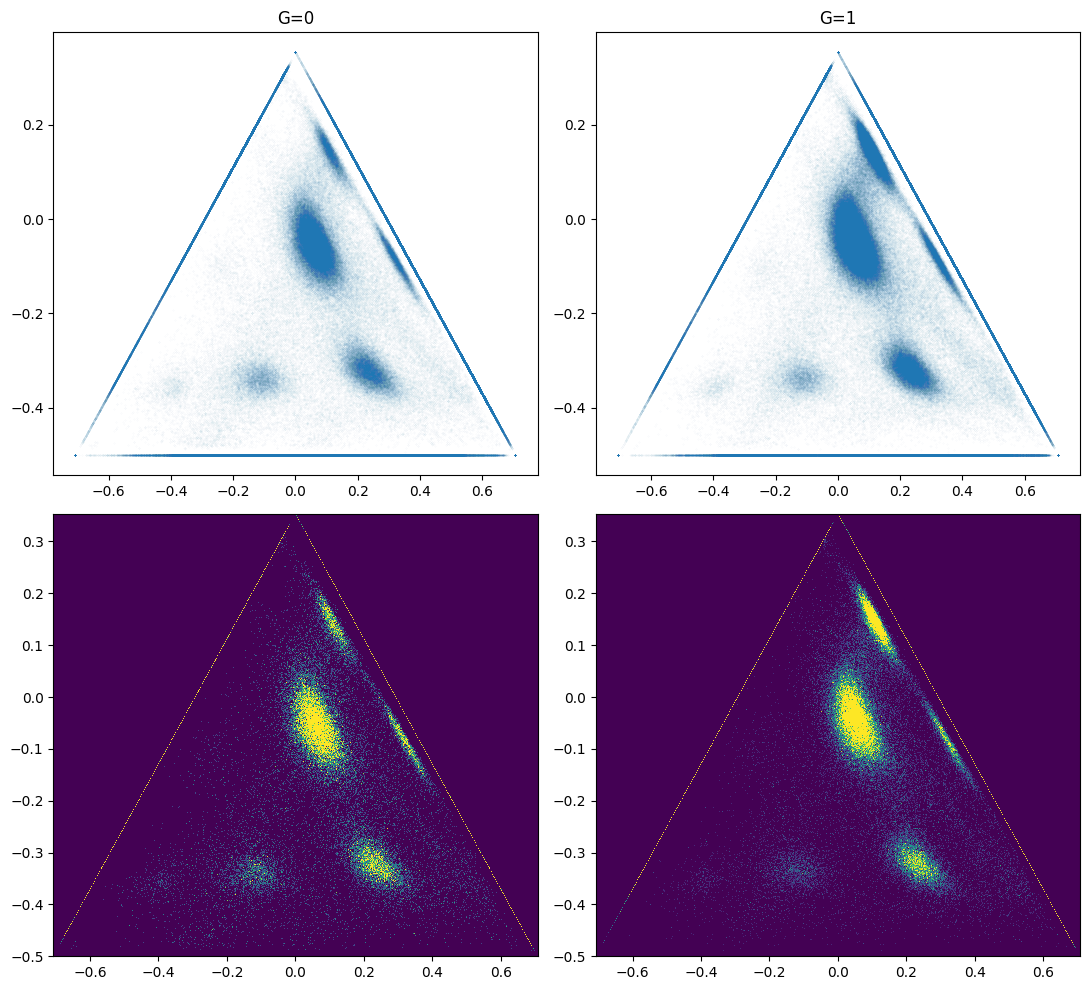

In [81]:
visualization(intensity_raw, G_layer=2, num_per_layer=15, bins=[1000, 1000], percentile_thre=99, )

## threshold

In [148]:
thre = 0.15

thre_index = []
cdfs_df = cdf_4d.copy()
for cluster_num in range(1, 31):
    tmp = cdf_4d.loc[intensity_fra_relabel['label'][intensity_fra_relabel['label']==(cluster_num)].index]
    tmp = tmp[tmp[cluster_num]>thre]
    thre_index += list(tmp.index)

thre_index.sort()
thre_index = pd.Index(thre_index)

print(f'thre={thre}\tpoints_kept: {len(thre_index) / len(intensity_raw) * 100 :.1f}%')

thre=0.15	points_kept: 86.7%


## visualization of threshold data

100%|██████████| 2/2 [00:01<00:00,  1.87it/s]


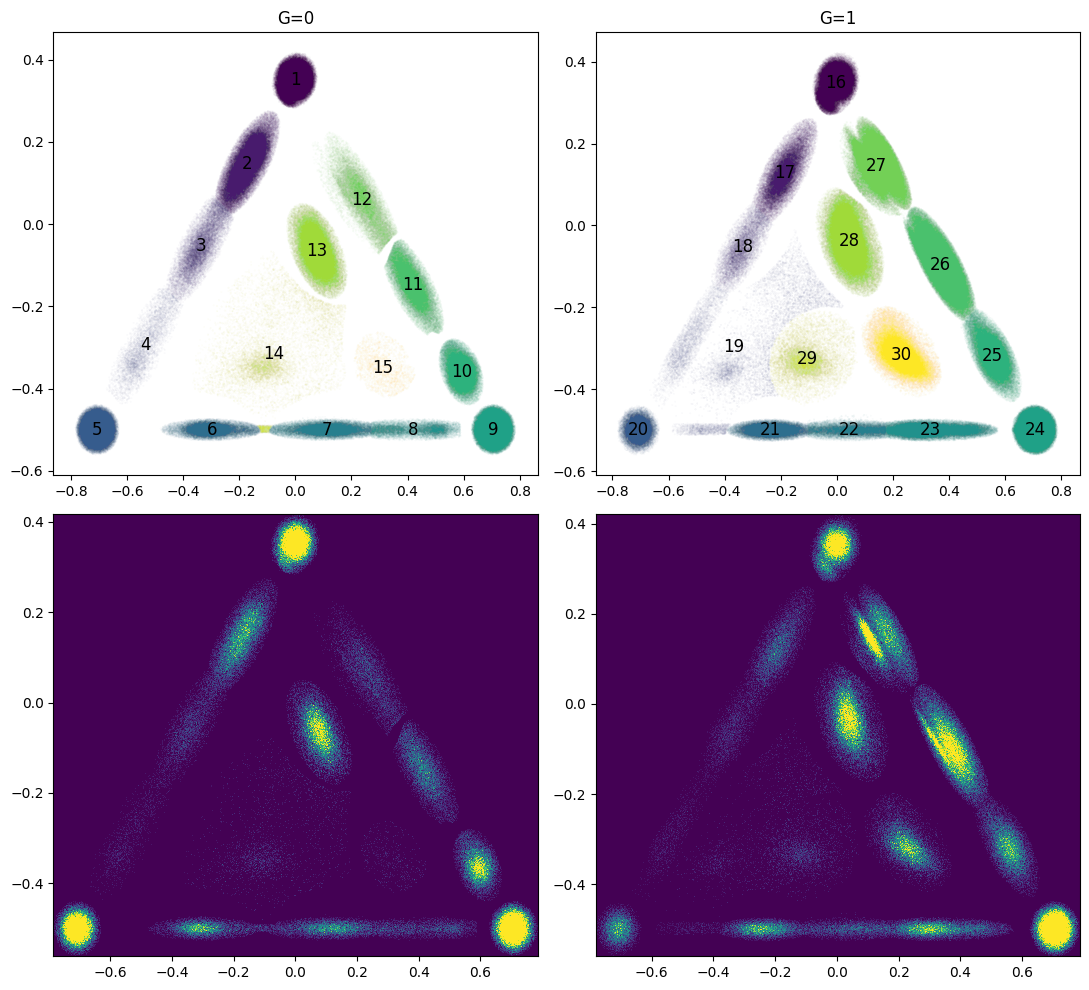

In [149]:
visualization(intensity_fra_relabel_xy_transformed.loc[thre_index],
              G_layer=2,
              num_per_layer=15,
              bins=[1000, 1000],
              percentile_thre=99,
              )

In [375]:
G_layer=1

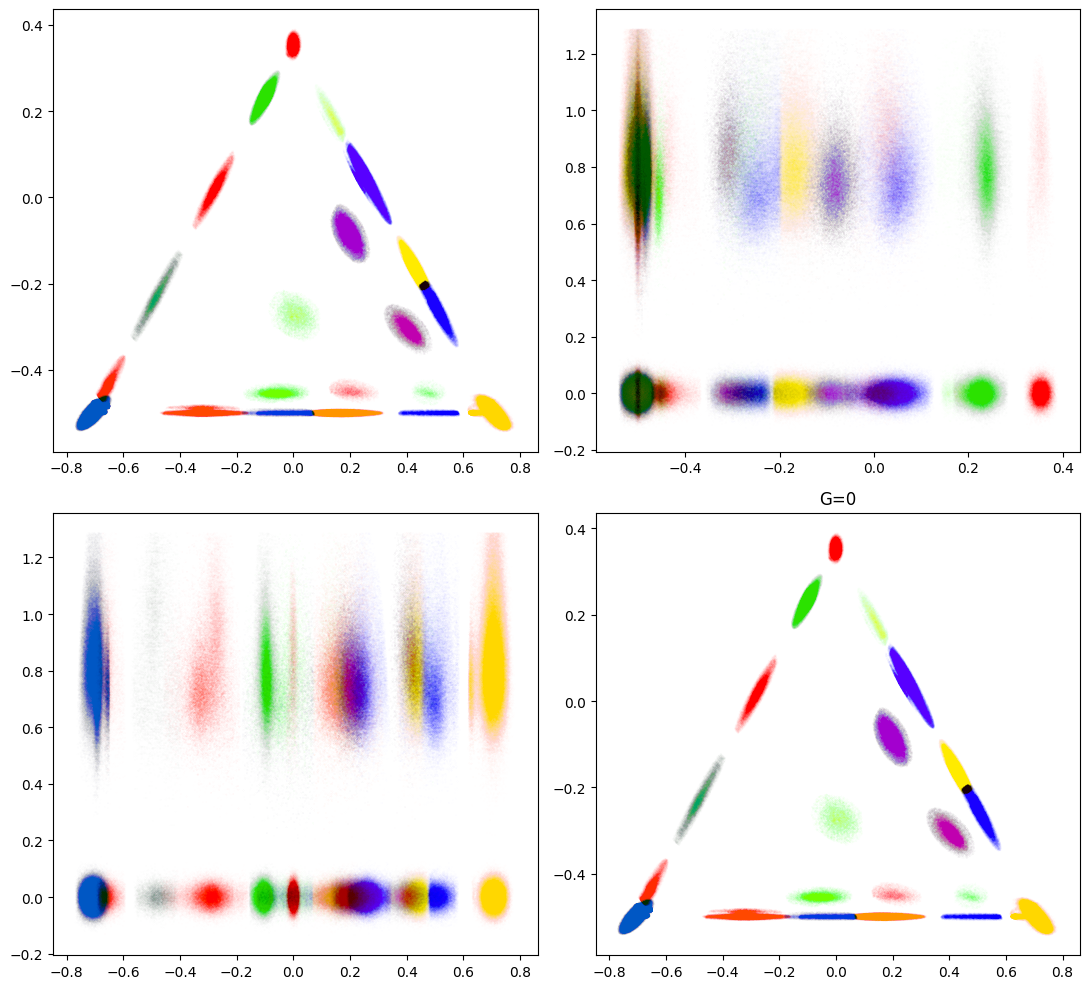

In [422]:
data = intensity_fra_relabel_xy_transformed.loc[thre_index]
s = 1 / np.log2(len(data)) / 10
alpha = 1 / np.log2(len(data))

n_rows = 2
n_cols = 2 - ( - (G_layer - 1) // 2 )

scatter_color = 'prism'

fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(5 * n_cols + 1, 10))
ax[1,0].scatter(data['X_coor_gaussian'], data['G/A'], c=data['label'], cmap=scatter_color, s=s, alpha=alpha, linewidths=None)
ax[0,1].scatter(data['Y_coor_gaussian'], data['G/A'], c=data['label'], cmap=scatter_color, s=s, alpha=alpha, linewidths=None)
ax[0,0].scatter(data['X_coor_gaussian'], data['Y_coor_gaussian'], c=data['label'], cmap=scatter_color, s=s, alpha=alpha, linewidths=None)

for layer in range(G_layer):
    ax_tmp = ax[(1 + layer) % n_rows, 1 - (-layer // n_rows)]
    ax_tmp.set_title(f'G={layer}')
    sub = data[data['G_layer'] == layer]
    ax_tmp.scatter(sub['X_coor_gaussian'], sub['Y_coor_gaussian'], c=sub['label'], cmap=scatter_color, s=s, alpha=alpha, linewidths=None)

plt.tight_layout()
plt.show()

## projection and export to image files

In [91]:
gene_name_list = pd.read_excel(r'E:\TMC\PRISM_gene_calling\dataset\20231221_PRISM64_Embryo_real\Embryo_Padlock_30plex.xlsx', sheet_name='Sheet1', index_col=0)['Gene Name']

In [150]:
gene_name_list = pd.read_csv(r'e:\TMC\PRISM_pipeline\dataset\processed\_example_dataset_processed\readout\PRISM_HCC_gene_list.csv', index_col=0)['gene']

In [151]:
gene_mapped = intensity_fra_relabel_xy_transformed.loc[thre_index][['X', 'Y', 'label']]

In [152]:
gene_mapped['label'].unique()

array([ 1, 16, 27, 17, 28, 13, 18,  2, 26, 12, 19, 14, 11, 29, 30,  3, 25,
       10, 15,  4, 22, 24,  9,  7, 23, 21,  5,  6, 20,  8], dtype=int64)

### demo and trial for one

In [ ]:
regions = []
for file in os.listdir(read_dir/'tmp'): 
    df = pd.read_csv(read_dir/'tmp'/file)
    regions.append({'xlim': [df['X'].min(), df['X'].max()], 'ylim': [df['Y'].min(), df['Y'].max()]})
    print('{}: {} points, xlim=[{}, {}], ylim=[{}, {}]'.format(
        file, len(df), df['X'].min(), df['X'].max(), df['Y'].min(), df['Y'].max()))

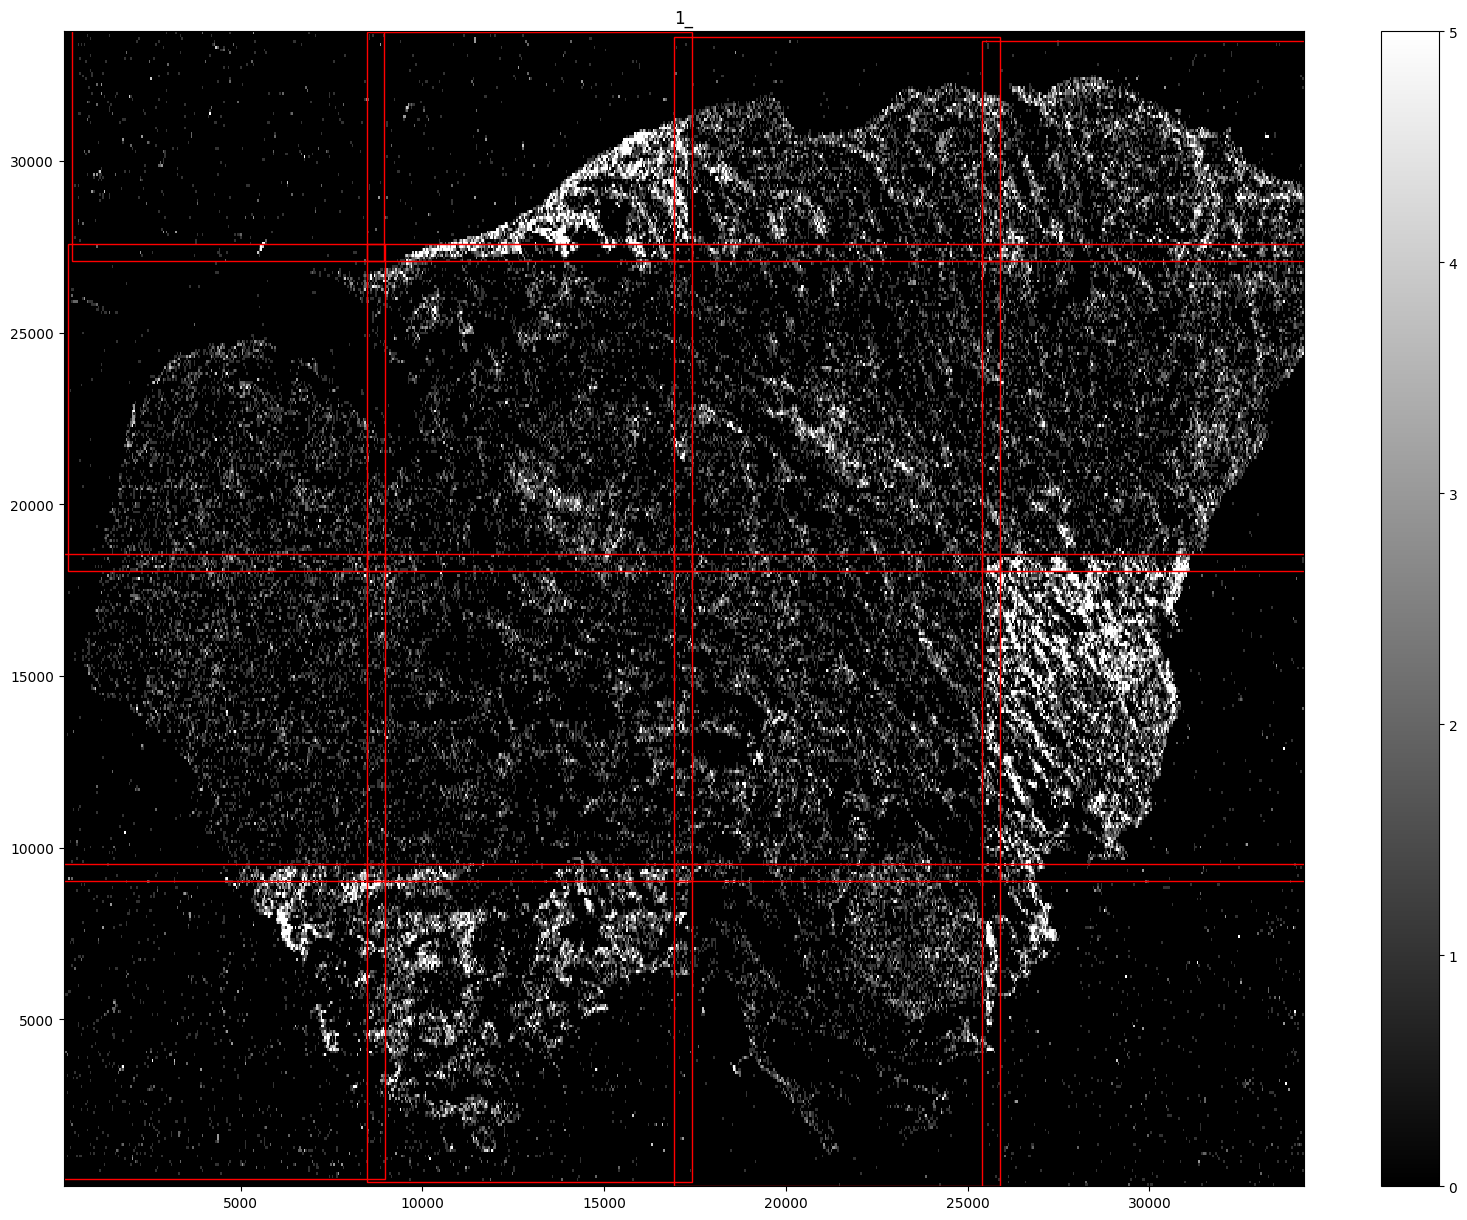

In [237]:
gene_order=1
# gene_name = gene_name_list.loc[gene_order]
gene_name = ''
points = gene_mapped[gene_mapped['label']==gene_order][['X', 'Y']].values

# Extracting x and y coordinates
x = points[:, 0]
y = points[:, 1]

bins = [800, 400]
# Creating the 2D histogram
hist, xedges, yedges = np.histogram2d(x, y, bins=bins)
percentile_99 = np.percentile(hist, 99)
percentile_10 = np.percentile(hist, 0)

fig, ax = plt.subplots(figsize=(20, 15))
plt.hist2d(x, y, 
            bins=bins, 
            vmax=percentile_99,
            vmin=0,
            cmap='gray',
            )

# Adding color bar to indicate the counts in the histogram
plt.colorbar()
plt.title(f'{gene_order}_{gene_name}')


import matplotlib.patches as patches
for region in regions:
    width = region['xlim'][1] - region['xlim'][0]
    height = region['ylim'][1] - region['ylim'][0]
    rect = patches.Rectangle((region['xlim'][0], region['ylim'][0]), width, height,
                             linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

plt.show()

### batch export 

#### use 2d hist and export to png files

In [415]:
out_path = os.path.join(workdir, 'sample_image_by_gene_ver2.0_G_removed_3rd_floor_thre=0.1', 'png')
os.makedirs(out_path, exist_ok=True)

for gene_order in range(1,22):
  gene_name = gene_name_list.loc[gene_order+42]
  points = gene_mapped[gene_mapped['label']==gene_order][['X', 'Y']].values
  # Extracting x and y coordinates
  x = points[:, 0]
  y = points[:, 1]

  # Creating the 2D histogram
  hist, xedges, yedges = np.histogram2d(x, y, bins=[200, 100])
  percentile = np.percentile(hist, 99)
  # percentile_10 = np.percentile(hist, 99)

  fig, ax = plt.subplots(figsize=(20, 10))
  plt.hist2d(x, y, 
              bins=[200, 100], 
              vmax=percentile,
              )

  # Adding color bar to indicate the counts in the histogram
  plt.colorbar()

  # Showing the plot
  plt.savefig(os.path.join(out_path, f'{gene_order+42}_{gene_name}.png'))
  plt.close()

#### export to tif files

In [416]:
from skimage.io import imsave
from glob import glob


def plot_density_downsample(im, df, filename, fac=100):
    y = (im.shape[0] // fac) + 1
    x = (im.shape[1] // fac) + 1
    coordinates = df[['Y','X']].to_numpy()
    canvas = np.zeros((y*fac,x*fac),dtype=np.uint16)
    canvas[coordinates[:,0],coordinates[:,1]] = 1
    canvas_down = canvas.reshape(y,fac,x,fac).sum(-1).sum(1)
    imsave(filename,canvas_down.astype(np.uint16),check_contrast=False)


out_path = os.path.join(workdir, 'sample_image_by_gene_ver2.0_G_removed_3rd_floor_thre=0.1', 'tif')
os.makedirs(out_path, exist_ok=True)

gene_mapped['Y'] = gene_mapped['Y'].astype(int)
gene_mapped['X'] = gene_mapped['X'].astype(int)

im = np.zeros((45381, 65102),dtype=np.uint16)

for gene_order in tqdm(range(1,22)):
    gene_name = gene_name_list.loc[gene_order+42]
    if glob(os.path.join(out_path, f'{gene_name}.tif')):
        continue
    else:
        df = gene_mapped[gene_mapped['label']==gene_order]
        plot_density_downsample(im, df, os.path.join(out_path, f'{gene_order+42}_{gene_name}.tif'))


  0%|          | 0/21 [00:00<?, ?it/s]

100%|██████████| 21/21 [01:19<00:00,  3.81s/it]


# visualization of color space

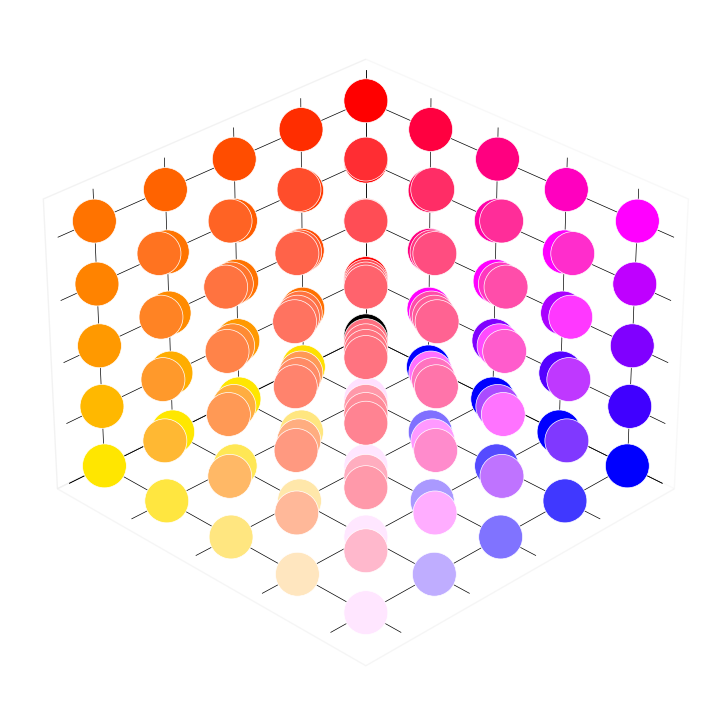

In [426]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Define the cube dimensions
cube_size = 5  # 0 to 4 inclusive (5 points)
point_size = 1000  # Adjust this value to change the size of the points

# Initialize lists to store points and their respective colors
points = []
colors = []

# Iterate through the x, y, and z coordinates
for x in range(cube_size):
    for y in range(cube_size):
        for z in range(cube_size):
            point = (x, y, z)  # Create a point with x, y, z coordinates
            points.append(point)  # Add the point to the list
            
            # Determine the color based on coordinates
            color = np.around(z / (cube_size - 1) * np.array([1, 0, 0]), decimals=2) + \
                    np.around(x / (cube_size - 1) * np.array([1, 0.9, 0]), decimals=2) + \
                    np.around(y / (cube_size - 1) * np.array([0, 0, 1]), decimals=2)
            max_color = np.max(color)

            # Add the color to the list
            if max_color != 0:
                colors.append(color / max_color)
            else:
                colors.append(color)  

# Convert colors to RGB format for visualization
rgb_colors = [(r, g, b) for r, g, b in colors]
# Create a 3D plot
fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(111, projection='3d')

# Plot points with its corresponding color and larger size
points = np.array(points)
ax.scatter(points[:, 0], points[:, 1], points[:, 2], color=rgb_colors, s=point_size, 
           alpha=1,
        #    edgecolor='k', linewidth=0.3,
           edgecolor='white', linewidth=0.5,
           )


for axis in [ax.w_xaxis, ax.w_yaxis, ax.w_zaxis]:
    # Set the gridline color to white where it overlaps with the axes
    axis._axinfo['grid']['color'] =  (1,1,1,0)
    # Hide the axis line
    axis.line.set_color((1,1,1,0))

max_range = 4.5
ticks = []

ax.set_xlim(0, max_range)
ax.set_ylim(0, max_range)
ax.set_zlim(0, max_range)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_zticks(ticks)

grid_color = 'black'
for val in range(5):
    ax.plot([0, 0], [0, max_range], [val, val], color=grid_color, linewidth=0.5,)
    ax.plot([0, max_range], [0, 0], [val, val], color=grid_color, linewidth=0.5,)
    ax.plot([val, val], [0, max_range], [0, 0], color=grid_color, linewidth=0.5,)
    ax.plot([val, val], [0, 0], [0, max_range], color=grid_color, linewidth=0.5,)
    ax.plot([0, max_range], [val, val], [0, 0], color=grid_color, linewidth=0.5,)
    ax.plot([0, 0], [val, val], [0, max_range], color=grid_color, linewidth=0.5,)

ax.xaxis.pane.set_facecolor((1.0, 1.0, 1.0, 0.0))  # Transparent pane for x-axis
ax.yaxis.pane.set_facecolor((1.0, 1.0, 1.0, 0.0))  # Transparent pane for y-axis
ax.zaxis.pane.set_facecolor((1.0, 1.0, 1.0, 0.0))  # Transparent pane for z-axis

ax.view_init(elev=30, azim=45)  # Set the elevation and azimuth angles
plt.show()

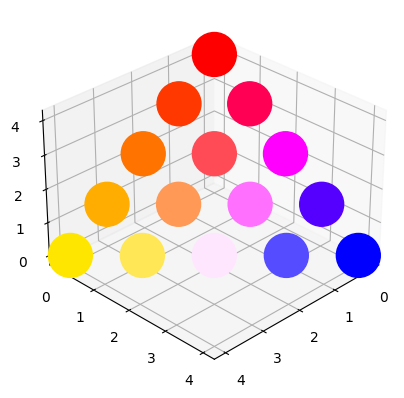

In [427]:
intersected_points = []
intersected_colors = []

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for i, point in enumerate(points):
    if sum(point) == 4:
        intersected_points.append(point)
        intersected_colors.append(rgb_colors[i])

intersected_points = np.array(intersected_points)

# Plot the points intersected by the specified plane
ax.scatter(intersected_points[:, 0], intersected_points[:, 1], intersected_points[:, 2], 
           color=intersected_colors, s=point_size, alpha=1)

# Set the viewpoint to focus on the origin (0, 0, 0)
ax.view_init(elev=30, azim=45)  # Set the elevation and azimuth angles